In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from scipy.stats import skew

pd.options.display.max_columns = 500

Снова потренируемся в предсказании цен на недвижимость из [очередного датасета с каггла](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/)! В качестве основной метрики для валидации моделей будем использовать, как и ранее, `MSLE`.

P.S. в данной домашней работе при построении любых моделей, использующих недетерменированные элементы (как бутстрап), в алгоритме указывайте параметр `random_state = 1` для воспроизводимости результатов.

In [5]:
df = (
    pd.read_csv('train_houses_reg.csv')
    .drop('Id', axis=1)
)

df

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60       RL         62.0     7917   Pave   NaN      Reg   
1456          20       RL         85.0    13175   Pave   NaN      Reg   
1457          70       RL         66.0     9042   Pave   NaN      Reg   
1458          20       RL         68.0     9717   Pave   NaN      Reg   
1459          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1            Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3            Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4            Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
...          ...       ...       ...       ...          ...        ...   
1455         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1456         Lvl    AllPub    Inside       Gtl       NWAmes       Norm   
1457         Lvl    AllPub    Inside       Gtl      Crawfor       Norm   
1458         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
1459         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam     2Story            7            5       2003   
1          Norm     1Fam     1Story            6            8       1976   
2          Norm     1Fam     2Story            7            5       2001   
3          Norm     1Fam     2Story            7            5       1915   
4          Norm     1Fam     2Story            8            5       2000   
...         ...      ...        ...          ...          ...        ...   
1455       Norm     1Fam     2Story            6            5       1999   
1456       Norm     1Fam     1Story            6            6       1978   
1457       Norm     1Fam     2Story            7            9       1941   
1458       Norm     1Fam     1Story            5            6       1950   
1459       Norm     1Fam     1Story            5            6       1965   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd       None   
2             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3             1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
1455          2000     Gable  CompShg     VinylSd     VinylSd       None   
1456          1988     Gable  CompShg     Plywood     Plywood      Stone   
1457          2006     Gable  CompShg     CemntBd     CmentBd       None   
1458          1996       Hip  CompShg     MetalSd     MetalSd       None   
1459          1965     Gable  CompShg     HdBoard     HdBoard       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0          196.0        Gd        TA      PConc       Gd       TA   
1            0.0        TA        TA     CBlock       Gd       TA   
2          162.0        Gd        TA      PConc       Gd       TA   
3            0.0        TA        TA     BrkTil       TA       Gd   
4          350.0        Gd        TA      PConc       Gd       TA   


In [6]:
### Разделим выборку на объекты-таргеты

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

### Логарифмируем таргет для будущей оптимизации
### MSLE через MSE

log_target = np.log1p(y)

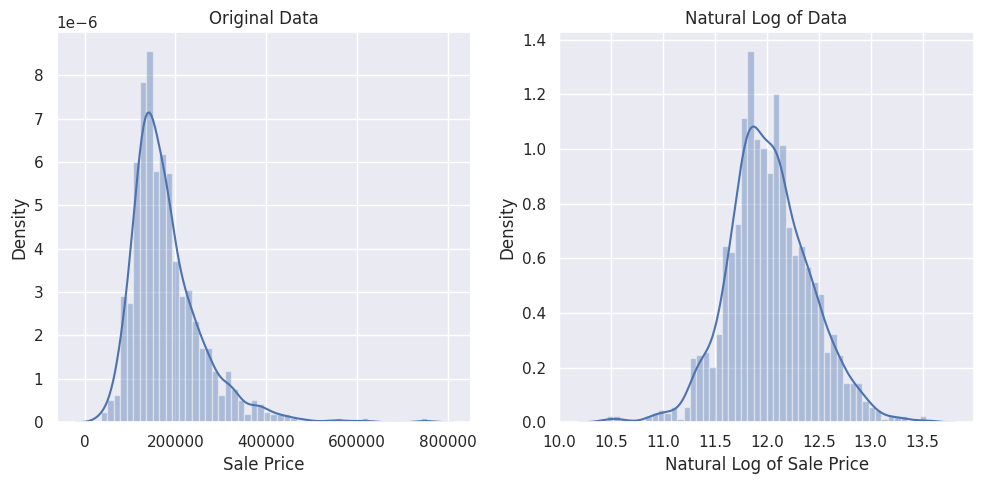

In [7]:
### Это позволяет получить нормальное распределение таргета
### Важно, например, для построения корректной
### С точки зрения статистических свойств
### Линейной модели.
### Хотя здесь мы будем строить ансамбли деревьев, 
### И это не особо интересно.

sns.set(rc={'figure.figsize':(15,10)})

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(y, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(log_target, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

### В начале поработаем с пропусками!

Если в какой-либо колонке оказывается достаточно много пропусков, обычно советуют от них избавляться. Мотивировано это тем, что в таких фичах мы можем наблюдать серьезный недостаток информативности, а заполнение пропусков может лишь внести лишнего шума в данные.

Избавьтесь от всех колонок, в которых пропусков оказывается больше 15%. (1б)

In [8]:
X.drop(X.columns[X.isna().mean() > 0.15], axis=1, inplace=True) #Избавьтесь от всех колонок, в которых пропусков оказывается больше 15%

In [9]:
X.shape[1]

73

In [10]:
cat = X[['MoSold','YrSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']]

In [11]:
for col in cat:
    most_recent = df.groupby(col).size().sort_values().index[-1] #MoSold, YrSold, GarageYrBlt, YearBuilt, YearRemodAdd Обработайте их как категориальные.
    df[col] = df[col].fillna(most_recent)


In [15]:
### Посмотрим на категориальные колонки
categorical_columns = X.loc[:,X.dtypes==np.object_].columns # категориальные колонки
X.loc[:,X.dtypes==np.object_].head(2)

MSZoning Street LotShape LandContour Utilities LotConfig LandSlope  \
0       RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
1       RL   Pave      Reg         Lvl    AllPub       FR2       Gtl   

  Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl  \
0      CollgCr       Norm       Norm     1Fam     2Story     Gable  CompShg   
1      Veenker      Feedr       Norm     1Fam     1Story     Gable  CompShg   

  Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation BsmtQual  \
0     VinylSd     VinylSd    BrkFace        Gd        TA      PConc       Gd   
1     MetalSd     MetalSd       None        TA        TA     CBlock       Gd   

  BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC  \
0       TA           No          GLQ          Unf    GasA        Ex   
1       TA           Gd          ALQ          Unf    GasA        Ex   

  CentralAir Electrical KitchenQual Functional GarageType GarageFinish  \
0          Y      SBrkr          Gd        Typ     Attchd          RFn   
1          Y      SBrkr          TA        Typ     Attchd          RFn   

  GarageQual GarageCond PavedDrive SaleType SaleCondition  
0         TA         TA          Y       WD        Normal  
1         TA         TA          Y       WD        Normal

In [16]:
# заменим пропуски в кат. колонках на  самые популярные
for col in categorical_columns:
    most_recent = X.groupby(col).size().sort_values().index[-1] 
    df[col] = X[col].fillna(most_recent)

In [17]:
X[categorical_columns].isna().sum()

MSZoning          0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        8
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
KitchenQual       0
Functional        0
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
PavedDrive        0
SaleType          0
SaleCondition     0
dtype: int64

In [20]:
### Посмотрим на некатегориальные колонки

numeric_columns = df.loc[:,df.dtypes!=np.object_].columns
df.loc[:,df.dtypes!=np.object_].head(2)

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          2003       196.0         706           0        150          856   
1          1976         0.0         978           0        284         1262   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0       856       854             0       1710             1             0   
1      1262         0             0       1262             0             1   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0         2         1             3             1             8           0   
1         2         0             3             1             6           1   

   GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
0       2003.0           2         548           0           61   
1       1976.0           2         460         298            0   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   

   SalePrice  
0     208500  
1     181500

In [21]:
# заменим пропуски в некат. колонках на медианы
for col in numeric_columns:
    df[col] = df[col].fillna(df[col].median())

In [22]:
df[numeric_columns].isna().sum()

MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SalePrice        0
dtype: int64

In [23]:
X.to_csv('my_dataframe.csv', sep=',', index=False)

Вещественные колонки заполните медианным значением по фиче, а категориальные - самой популярной по колонке категорией. (2б)

Заметьте, что колонки `MoSold`, `YrSold`, `GarageYrBlt`, `YearBuilt`, `YearRemodAdd` хоть в таблице не являются типами `object`, вряд ли их справедливо использовать как вещественные. Обработайте их как категориальные.

In [24]:
### Разделим выборку на объекты-таргеты

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

### Логарифмируем таргет для будущей оптимизации
### MSLE через MSE

log_target = np.log1p(y)

In [25]:
### Отложенная выборка

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    log_target, 
                                                    test_size=0.25, 
                                                    random_state=1)

Напишите трансформер, который будет делать следующее:

1. Масштабирование через StandardScaler для вещественных колонок
2. Кодирование через OneHotEncoder для категориальных, содержащих менее, чем 5 уникальных значений
3. Кодирование через TargetEncoder для всех остальных категориальных

Для этого советуем воспользоваться библиотекой `category_encoders` помимо `sklearn`.

А так же классом `ColumnTransformer` из `sklearn.compose`.

P.S. Напомним, что для деревьев процедура StandardScaling не обязательна (решающие деревья нечувствительны к масштабу). Тем не менее, это может сделать обучение модели менее тяжелым (хранить большие числа сложно для задач с большим количеством данных).

In [26]:
!pip install category-encoders

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [27]:
object_cols = categorical_columns

In [28]:
X[object_cols] = X[object_cols].astype(object)
X_test[object_cols] = X_test[object_cols].astype(object)
X_train[object_cols] = X_train[object_cols].astype(object)

X.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd             7        Typ           

In [29]:
### Запишем заранее колонки для OHE
### и счетчиков
### а также вещественные колонки


cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]
numeric_cols = list(X_train.select_dtypes(exclude='object').columns)

### сохраним индексы этих колонок

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_cols]

In [30]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### Your code is here
t = [('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
     ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx),
     ('StandardScaler', StandardScaler(), numeric_cols_idx)]

col_transform = ColumnTransformer(transformers=t)


Посмотрите, как на наших данных справляется одно Решающее Дерево с дефолтными гиперпараметрами. Добавьте написанный ранее трансформер в модель. (1б)

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Your code is here

pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("decision_tree", 
                     DecisionTreeRegressor())])

pipe_dt.fit(X_train, y_train)


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [4, 6, 7, 8, 10, 24, 26, 29,
                                                   30, 31, 39, 40, 52, 59,
                                                   64]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [1, 9, 11, 12, 13, 14, 15, 20,
                                                   21, 22, 23, 27, 28, 32, 34,
                                                   38, 41, 54, 57, 62, 63, 77,
                                                   78]),
                                                 ('StandardScaler',
                                                  StandardScaler(),
                                                  [0, 2, 3, 16, 17, 18, 19, 25,
                                                   33, 35, 36, 37, 42, 43, 44,
                                                   45, 46, 47, 48, 49, 50, 51,
                                                   53, 55, 58, 60, 61, 65, 66,
                                                   67, ...])])),
                ('decision_tree', DecisionTreeRegressor())])

In [32]:
pipe_dt.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [4, 6, 7, 8, 10, 24, 26, 29,
                                                   30, 31, 39, 40, 52, 59,
                                                   64]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [1, 9, 11, 12, 13, 14, 15, 20,
                                                   21, 22, 23, 27, 28, 32, 34,
                                                   38, 41, 54, 57, 62, 63, 77,
                                                   78]),
                                                 ('StandardScaler',
                                                  StandardScaler(),
         

In [33]:
train_preds = pipe_dt.predict(X_train)
test_preds = pipe_dt.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error}")
print(f"Качество на тесте: {round(test_error,3)}")

Качество на трейне: 8.645051016120677e-33
Качество на тесте: 0.042


Справляется даже без контроля переобучения!

Посмотрим на перформанс Случайного Леса! Подберите параметры по отложенной выборке по данной сетке `param_grid`. Помните, что подбирать количество деревьев не супер обязательно, достаточно поставить их побольше. Что произошло с качеством модели по сравнению с одиноким деревом? (2б)

In [34]:
from sklearn.ensemble import RandomForestRegressor

RandomForest_pipe = Pipeline([("column_transformer",
                               col_transform),
                  
                              ("random_forest", 
                               RandomForestRegressor())])

RandomForest_pipe.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [4, 6, 7, 8, 10, 24, 26, 29,
                                                   30, 31, 39, 40, 52, 59,
                                                   64]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [1, 9, 11, 12, 13, 14, 15, 20,
                                                   21, 22, 23, 27, 28, 32, 34,
                                                   38, 41, 54, 57, 62, 63, 77,
                                                   78]),
                                                 ('StandardScaler',
                                                  StandardScaler(),
                                                  [0, 2, 3, 16, 17, 18, 19, 25,
                                                   33, 35, 36, 37, 42, 43, 44,
                                                   45, 46, 47, 48, 49, 50, 51,
                                                   53, 55, 58, 60, 61, 65, 66,
                                                   67, ...])])),
                ('random_forest', RandomForestRegressor())])

In [35]:
RandomForest_pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [4, 6, 7, 8, 10, 24, 26, 29,
                                                   30, 31, 39, 40, 52, 59,
                                                   64]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [1, 9, 11, 12, 13, 14, 15, 20,
                                                   21, 22, 23, 27, 28, 32, 34,
                                                   38, 41, 54, 57, 62, 63, 77,
                                                   78]),
                                                 ('StandardScaler',
                                                  StandardScaler(),
         

In [36]:
y_train.shape[0]

1095

In [37]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [38]:
RandomForest_pipe_GSCV = Pipeline([("column_transformer",
                               col_transform),
                  
                              ("random_forest", 
                               RandomForestRegressor())])

In [40]:
np.random.seed(1)

custom_cv = [(X_train.index.to_list(), X_test.index.to_list())]

param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

### Your code is here
search1 = GridSearchCV(RandomForest_pipe_GSCV, 
                      param_grid, 
                      cv=custom_cv,
                      scoring='neg_mean_squared_error',
                      n_jobs = -1,
                      verbose=10)

search1.fit(X, log_target)

print(f"Best parameter (CV score={search1.best_score_:.5f}):")
print(search1.best_params_)

print(f"Качество лучшей модели на финальном тесте: {-search1.score(X_test, y_test)}")


Fitting 1 folds for each of 27 candidates, totalling 27 fits
Best parameter (CV score=-0.01825):
{'random_forest__max_depth': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 5}
Качество лучшей модели на финальном тесте: 0.0031769761325660287


Попробуем теперь поэкспериментировать с бэггингами. 

Постройте бэггинги с 100 базовыми моделями (и остальными стандартными параметрами) над линейной регрессией, деревом и случайным лесом (бэггинг над бэггингом!). 

Какое качество у каждой модели на тесте?

Какой алгоритм получился лучше с точки зрения качества на тесте? (2б)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

### Your code is here



Улучшил ли бэггинг над Лесом качество по сравнению с одним Лесом с точки зрения как качества на тесте, так и на трейне. Как это можно объяснить? Как думаете, много ли смысла в использовании бэггинга над линейными моделями? Выбрали бы вы в данной ситуации именно их в качестве базовых?

### Добавим новые фичи!

Создайте следующие четыре новые вещественные фичи:

1. Отношения площади 1 этажа к общей площади (колонки 1stFlrSF и GrLivArea, в %)
2. Отношение Площади завершенного фундамента первого типа к общей площади фундамента (колонки BsmtFinSF1 и TotalBsmtSF, в %)
3. Возраст дома (между YearBuilt и YrSold)
4. Общая площадь самого дома и фундамента/цоколя (1stFlrSF + 2ndFlrSF + TotalBsmtSF)

Обучите заново Случайный лес и найдите лучшие гиперпараметры на старой сетке.

Улучшили ли качество модели новые фичи? (4б)

In [ ]:
### Your code is here

